# 1. 데이터셋 불러오기
데이터셋은 torchvision 패키지에서 제공하는 STL10 dataset을 이용한다. STL10 dataset은 10개의 label을 갖고 있으며, train dataset 5000개, test dataset 8000개로 구성된다.

필요한 라이브러리를 import 한다.

In [12]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os

# display images 
from torchvision import utils
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy

데이터셋 다운받을 경로를 지정하고, 데이터셋을 불러온다.

In [9]:
# specify the data path
path2data = r'C:\Users\camar\OneDrive\바탕 화면\ResNet'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train',
                          download=True, transform=transfroms.ToTensor())
val_ds = datasets.STL10(path2data, split='test',
                        download=True, transform=transfroms.ToTensor())

print(len(train_ds))
print(len(val_ds))

100.0%


Extracting C:\Users\camar\OneDrive\바탕 화면\ResNet\stl10_binary.tar.gz to C:\Users\camar\OneDrive\바탕 화면\ResNet
Files already downloaded and verified
5000
8000


이미지에 Normalization을 적용하기 위해, 이미지 픽셀값의 평균, 표준편차를 계산한다.

In [11]:
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])

val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in train_stdRGB])
val_stdG = np.mean([s[1] for s in train_stdRGB])
val_stdB = np.mean([s[2] for s in train_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)

0.4467106 0.43980986 0.40664646
0.44723064 0.4396425 0.40495726


dataset에 적용할 transform을 정의한다.

In [13]:
# define the image transformaion
train_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
    transforms.RandomHorizontalFlip(),
])

val_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB]),
])

trainsformation을 dataset에 적용하고 dataloader를 생성한다.

In [14]:
# apply transformation
train_ds.transform = train_transformation
val_ds.transform = val_transformation

# create DataLoader
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=True)

transformation이 적용된 샘플 이미지를 확인해보자.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [ 235 3980  905 2763]


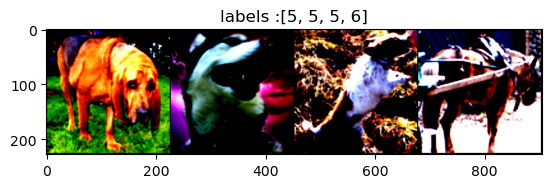

In [17]:
# display smaple images
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

np.random.seed(1)
torch.manual_seed(1)

grid_size = 4
rnd_inds = np.random.randint(0, len(train_ds), grid_size)
print('image indices:', rnd_inds)

x_grid = [train_ds[i][0] for i in rnd_inds]
y_grid = [train_ds[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

# 2. 모델 구축하기
ResNet-18, 34는 residual block을 사용하고, ResNet-50부터는 bottleNeck을 사용한다.

각각의 residual block을 정의한다.

In [19]:
class BasicBlock(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정한다.
        self.residual_function = nn.Sequential(
            nn.conv2d(in_channels, out_channels,
                      kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels*BasicBlock.expansion, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels*BasicBlock.expansion),
        )

        # identity mapping, input 과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()

        # BatchNorm에 bias가 포함되어 있으므로, conv2d는 bias=False로 설정한다.
        self.residual_function = nn.Sequential(
            nn.conv2d(in_channels, out_channels,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels*BasicBlock.expansion),
        )

        # identity mapping, input 과 output의 feature map size, filter 수가 동일한 경우 사용.
        self.shortcut = nn.Sequential()
        self.relu = nn.ReLU()

        # projection mapping using 1x1conv
        if stride != 1 or in_channels != BasicBlock.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BasicBlock.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BasicBlock.expansion)
            )

    def forward(self, x):
        x = self.residual_function(x) + self.shortcut(x)
        x = self.relu(x)
        return x

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, num_block, num_classes=10, init_weights=True):
        super().__init__()

        self.in_channels = 64

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2,
                      padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.conv2_x = self._make_layer(block, 64, num_block[0], 1)
        self.conv3_x = self._make_layer(block, 128, num_block[1], 2)
        self.conv4_x = self._make